# Introduction

Stock is really big nowadays. Everyone is doing it to get some money out of it, but there’s really no set equation to earn big money. However, what if you can predict the increase or decrease in stocks by analyzing articles? Afterall, what happens to big corporations tends to be on the news, and based on what happen to a corporation, the stock price changes. So why not analyze the news article and predict if stock price will increase toward our favor or not? In making this possible, we have this tool called Text Sentiment Analysis API offered by Google Cloud that we can use to analyze the sentiment of a document. What we’ll be doing is scrape a few articles from big publishers like Forbes about a given corporation and compare the ratio of positive and negative articles. If there’s more positive articles than negative articles, we’ll predict that the stock price for that corporation would go up and same thing for the other case. 


In [30]:
pip install google-cloud-language

Note: you may need to restart the kernel to use updated packages.


In [31]:
pip install --upgrade google-cloud-language

Requirement already up-to-date: google-cloud-language in /Users/wonwoonam/opt/anaconda3/lib/python3.8/site-packages (2.0.0)
Note: you may need to restart the kernel to use updated packages.


In [32]:
pip install MechanicalSoup

Note: you may need to restart the kernel to use updated packages.


# Setting up
Now, in order to use the API, you must register yourself in Google Cloud and get the client key json file. Because this is too much of a work that involves billing information and other sensitive information, I went ahead and made a temporary account and provided you with the key json file. (Do not overuse this key)


In [33]:
from google.cloud import language_v1
import matplotlib.pyplot as plt
import mechanicalsoup
import os
import sys

# Coding
Let us now get into coding. You first have to install google-cloud language as well as upgrade it. Then, you also need to install MechanicalSoup. MechanicalSoup will be useful in the process of web scraping and google-cloud language will be useful in using the Sentiment Analysis API.

Before moving onto the actual code, we’ll first setup the client to use the Sentiment Analysis API. As mentioned above, the json file with private key is provided. Make sure the file is on the same folder as this file (app.py).

In [34]:
fileName = "key.json"
scriptDir = os.path.dirname(os.path.realpath('__file__'))
a = os.path.join(scriptDir, fileName)
client = language_v1.LanguageServiceClient.from_service_account_json(a)

# Scraping Data
In this section, we’ll be scraping data and returning the dataset of sentiment scores given a keyword. To describe the general procedure, we first declare a StatefulBrowser using Mechanicalsoup to interact with HTML elements. Then, we find the class that corresponds to the articles that we want to extract from Forbes. This is pretty similar to what we did with homework on Yelp API so this shouldn’t be that hard to understand. (In this tutorial, we’re using MechanicalSoup, not BeautifulSoup, because MechanicalSoup lets us do so much more with less lines of code when it comes to web scraping)


In [35]:
#Forbes Example
brw1 = mechanicalsoup.StatefulBrowser()
url1 = "https://www.forbes.com/search/?q=%s" % ('tesla')
brw1.open(url1)
links1 = brw1.page.find_all(class_="stream-item et-promoblock-removeable-item et-promoblock-star-item")

The only downside of this is that you have to go to each of the website to find the format in which the articles are arranged in. As you can see when running the above code, 'links' just returns the class names and it's not so pretty to look at the class names in such a long list, so we'll try converting these class names into actual texts. But first, I have a few other examples of opening up the websites and collecting class names for other publishers.

In [36]:
#New York Times Example
brw2 = mechanicalsoup.StatefulBrowser()
url2 = "https://www.nytimes.com/search?query=%s" % ('tesla')
brw2.open(url2)
links2 = brw2.page.find_all(class_="css-1l4w6pd")

Now we'll take a look at how the classifications of the articles are converted into actual documents of the articles' text. Below is just another step to ensure we go as deep into the websites' hiearchy as where we should go to scrape the articles. 

In [37]:
href = links1[0].a.get('href')
brw1.open(href)
class_dict1 = {"class":"article-body fs-article fs-responsive-text current-article"}
body = brw1.page.find('div', class_dict1)

Next, we will go into the actual analysis of the text sentiment. Surprisingly, this can be done with one line of code. But before that, we have to finish our extraction of the article text. To do this, we have to make sure the body we extracted above is not 'None' and then combine all the paragraphs for each article to have it analyzed for the sentimentality.

In [38]:
if body:
    txts = []
    contents = body.find_all('p')
    for ext in contents:
        txts.append(ext.getText())
        text = (" ".join(txts))
        document = language_v1.Document(content=text, type_=language_v1.Document.Type.PLAIN_TEXT)
        sentiment = client.analyze_sentiment(request={'document': document}).document_sentiment

So this is it for analyzing sentiment of an article and we'll go right ahead in making a function that takes in a keyword of the corporation and returns the list of sentiment scores.

In [39]:
def forbesSentiment(keyword, num):
    brw = mechanicalsoup.StatefulBrowser()
    brw.open("https://www.forbes.com/search/?q=%s" % (keyword))
    links = brw.page.find_all(class_="stream-item et-promoblock-removeable-item et-promoblock-star-item")
    lst = []
    limit = 0
    for lk in links:
        if limit == num:  
            break
        href = lk.a.get('href')
        brw.open(href)
        class_dict = {"class":"article-body fs-article fs-responsive-text current-article"}
        body = brw.page.find('div', class_dict )
        if not body:    
            continue
        txts = []
        contents = body.find_all('p')
        for ext in contents:
            txts.append(ext.getText())
        text = (" ".join(txts))
        document = language_v1.Document(content=text, type_=language_v1.Document.Type.PLAIN_TEXT)
        sentiment = client.analyze_sentiment(request={'document': document}).document_sentiment
        lst.append(sentiment.score)
        limit += 1
    brw.close()
    return lst    

To compare how the sentiment scores are different for each publishers, I've integrated a function that finds a list of sentiment scores from New York Times articles. This way, we can compare if one publisher is more negatively driven when writing articles than others.

In [40]:
def nyTimesSentiment(keyword, num):
    brw = mechanicalsoup.StatefulBrowser()
    brw.open("https://www.nytimes.com/search?query=%s" % (keyword))
    links = brw.page.find_all(class_="css-1l4w6pd")
    base = 'https://www.nytimes.com'
    lst = []
    limit = 0
    for lk in links:
        if limit == num:  
            break
        href = lk.a.get('href')
        full = base + href
        brw.open(full)
        body = brw.page.find('section', {"name":"articleBody"})
        if not body:    
            break
        txts = []
        contents = body.find_all('p')
        for ext in contents:
            txts.append(ext.getText())
        text = (" ".join(txts))
        document = language_v1.Document(content=text, type_=language_v1.Document.Type.PLAIN_TEXT)

        sentiment = client.analyze_sentiment(request={'document': document}).document_sentiment
        lst.append(sentiment.score)
        limit += 1
    brw.close()
    return lst    

In [41]:
if __name__ == '__main__':
    print("Forbes Sentiment Scores: ")
    print(forbesSentiment('tesla', 10))
    print("New York Times Sentiment Scores: ")
    print(nyTimesSentiment('tesla', 10))
    

Forbes Sentiment Scores: 
[-0.10000000149011612, 0.0, 0.10000000149011612, 0.0, 0.0, -0.10000000149011612, -0.20000000298023224, 0.0, 0.0, 0.0]
New York Times Sentiment Scores: 
[-0.10000000149011612, -0.4000000059604645, -0.20000000298023224, -0.6000000238418579, -0.10000000149011612, -0.30000001192092896, -0.30000001192092896, 0.0, -0.10000000149011612, 0.0]


As an additional visualization, we can plot the data using plt.hist. Increasing the number of articles to analyze will greatly increase the number of runtime, but by looking at the plotted graph, we can see if the articles are focused in the negative scores or the positive scores.

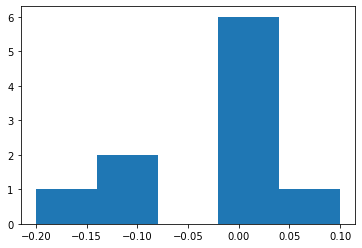

In [42]:
dta = forbesSentiment('tesla', 20)
plt.hist(dta, bins = 5)
plt.show()

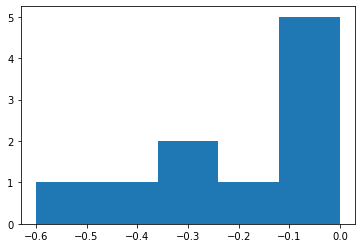

In [43]:
dta = nyTimesSentiment('tesla', 20)
plt.hist(dta, bins = 5)
plt.show()

Although the amount of data is insufficient, we can see that New York Times has more negative inclination than Forbes on articles about 'Tesla'.

# Comparing Data
Now that we have scraped data and got a sentiment analysis on those data, we'll compare our prediction with the actual stock data set. We will use API from alphavantage and compare the data from yesterday's stock price change with our prediction on 10 most recent articles. 

The connection here has been written about in various papers and is used in some startups. If you want to learn and read more about this topic, here are some of the links to the papers written on this topic: 

Paper1: https://arxiv.org/pdf/1812.04199.pdf

Paper2: https://www.tandfonline.com/doi/full/10.1080/24751839.2021.1874252#:~:text=1.-,Introduction,with%20positive%20or%20negative%20sentiments


Let us now dig into coding so that we know if this theory is valid!

In [44]:
import io, time, json
import requests
from datetime import datetime, timedelta

For the sake of consistency, we'll use Tesla as the key corporation of analyzation.

In [45]:
key = "AIOG7263S8YMMVNI"
url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=TSLA&outputsize=1&apikey="+key
response = requests.get(url)
jsonData = response.json()
daily_data = jsonData['Time Series (Daily)']

In the next snippet of code, we're basically getting yesterday's date and comparing the change of stock market price for Tesla by looking at opening price and closing prices.

In [46]:
yesterday = datetime.now() - timedelta(1)
temp = datetime.date(yesterday)
wkday = temp.weekday()
if wkday == 5:
    yesterday = datetime.now() - timedelta(2)
elif wkday == 6:
    yesterday = datetime.now() - timedelta(3)

yesterday = datetime.strftime(yesterday, '%Y-%m-%d')

In [47]:
ystrday_data = daily_data[yesterday]
open_val = ystrday_data['1. open']
open_val = float(open_val)
close_val = ystrday_data['4. close']
close_val = float(close_val)

In [48]:
stock_change = ""
if open_val > close_val:
    stock_change = "decreased"
elif open_val < close_val:
    stock_change = "increased"
else:
    stock_change = "no change"

The code below sorts positive sentiment scores from negative scores and predict that the stock price will decrease if there's more negative scores than positive scores as well as the other way around.

In [49]:
company = 'tesla'
stment_scores = forbesSentiment(company, 10)
neg_count = 0
pos_count = 0
for scores in stment_scores:
    if scores>0:
        pos_count +=0
    elif scores<0:
        neg_count +=0

In [50]:
prdiction = ""
if neg_count > pos_count:
    prdiction = "decreased"
elif pos_count > neg_count:
    prdiction = "increased"
else:
    prdiction = "no change"

Then we compare the prediction from the actual data in order to see if our prediction was correct or not. Really, to make this equation work, I would have to compare what my prediction was with the stock price for that day, but the Alphavantage API doesn't offer current date's stock data. Therefore, we'll just work with the most recent data set avilable. 

In [51]:
if stment_scores == prdiction:
    result = "Accurate Prediction"
else:
    result = "Wrong Prediction"
print(result)

Wrong Prediction


This tutorial was for me to briefly explain how the stock market could be predicted with sentimental analysis of articles. As mentioned before, there are papers published about this topic and because I didn't want to follow exactly the procedures that they took in those papaers, this was a chance for me to prove the theory in my own very way. So feel free to give me some comments on what should've been done or what you liked about this tutorial. If you want to learn more about this topic and about the google clound api, refer to the link that I attached in above and to this link: https://cloud.google.com/natural-language/docs/reference/libraries